In [128]:
import test_config as cfg
import numpy as np
import itertools, functools

%matplotlib inline
import matplotlib.pyplot as plt
import sys, os, os.path, time
import pickle, io, json

import skimage, skimage.io, skimage.transform, skimage.filters
import sklearn, sklearn.metrics

import importlib
sys.path.append('../src/')
import modutils
import word_processing as wp
import tqdm
import tensorflow as tf
import editdistance

In [121]:
fname = 'D:/Data/HTR/train.txt'
path = '.'.join(fname.split('.')[:-1])
train_sample = [tuple(y.strip() for y in x.split(' ')) for x in open(fname, 'r').readlines()]

In [123]:
class BaseTransformer:
    def __init__(self):
        pass
    def transform(self, x):
        pass

    
class SequentialTransformer:
    def __init__(self, *args):
        self.stages_ = args
        
    def transform(self, x):
        res = x
        for s in self.stages_:
            res = s.transform(res)
        return res
    
class LoadImageTransformer(BaseTransformer):
    def __init__(self, path):
        self.path_ = path
        
    def transform(self, x):
        if type(x) != str:
            raise Exception("LoadImageTransformer: expects filename as argument!")
        return skimage.io.imread(os.path.join(self.path_, x), as_grey=True)
    
class ConvertFloatTransformer(BaseTransformer):
    def __init__(self, min_value = 0.0, max_value = 1.0):
        self.min_ = min_value
        self.max_ = max_value
        
    def transform(self, x):
        if x.dtype in (np.float, np.float64, np.float32):
            return x
        if x.dtype == np.uint8:
            return (x / 255.0) * (self.max_ - self.min_) + self.min_
        if x.dtype == np.uint16:
            return (x / 65535.0) * (self.max_ - self.min_) + self.min_
        raise Exception("ConvertFloatTransformer: unexpected argument type!")
    
class RandomStretchTransformer(BaseTransformer):
    def __init__(self, min_scale = 0.66, max_scale = 1.5, fill_value=1.0):
        self.max_ = max_scale
        self.min_ = min_scale
        self.fill_ = fill_value
        
    def transform(self, x):
        f = np.random.uniform(self.min_, self.max_)
        return skimage.transform.rescale(x, (1.0, f), mode='constant', cval=self.fill_)
    
class TransposeTransformer(BaseTransformer):
    def __init__(self):
        pass
    def transform(self, x):
        return np.transpose(x)
    
class FitSizeTransformer(BaseTransformer):
    def __init__(self, width, height, fill_value=1.0):
        self.w_ = width
        self.h_ = height
        self.fill_ = fill_value
        self.template_ = np.ones((self.h_, self.w_)) * self.fill_
        
    def transform(self, x):
        (h, w) = x.shape
        f = max(w / self.w_, h / self.h_)
        res = self.template_.copy()
        rw = max(min(self.w_, int(w / f)), 1)
        rh = max(min(self.h_, int(h / f)), 1)
        res[0:rh, 0:rw] = skimage.transform.resize(x, (rh, rw), mode='constant', cval=self.fill_)
        return res
    
class StandardizeTransformer(BaseTransformer):
    def __init__(self):
        pass
    
    def transform(self, x):
        m = np.mean(x)
        s = np.std(x)
        if s <= 1e-9:
            return x - m
        return (x - m) / s
    
class TruncateLabelTransform(BaseTransformer):
    def __init__(self, max_cost):
        self.max_cost_ = max_cost
        
    def transform(self, x):
        if type(x) != str:
            raise Exception("TruncateLabelTransform: input expected to be of type string!")
        cost = 0
        for i in range(len(x)):
            flg = (i > 0) and (x[i] == x[i-1])
            cost += 1 + int(flg)
            if cost > max_cost:
                return x[:i]
        return x

In [159]:
class HTRModel:
    def __init__(self, charlist, img_size=(128, 32), text_len=32,
                 cnn_kernels = [5, 5, 3, 3, 3],
                 cnn_features = [1, 32, 64, 128, 128, 256],
                 cnn_pools = [(2,2), (2,2), (1,2), (1,2), (1,2)],
                 cnn_strides = None,
                 rnn_cells = [256, 256],
                 decoder = 'best-path',
                 model_path = '/htr-model/',
                 restore=False):
        self.chars_ = charlist
        self.restore_ = restore
        self.epochID_ = 0
        self.img_size_ = img_size
        self.text_len_ = text_len
        
        self.cnn_kernels_ = cnn_kernels
        self.cnn_features_ = cnn_features
        self.cnn_pools_ = cnn_pools
        self.cnn_strides_ = cnn_strides
        if cnn_pools is None and cnn_strides is None:
            raise Exception("Must specify at least one of `pools` and `strides`!")
        if cnn_pools is None:
            self.cnn_pools_ = cnn_strides
        if cnn_strides is None:
            self.cnn_strides_ = cnn_pools
        self.rnn_cells_ = rnn_cells
        self.model_path_ = model_path
        
        if decoder not in ('best-path', 'beam-search'):
            raise Exception("HTRModel: unknown decoder name `{}`. Expected `best-path` or `beam-search`".format(decoder))
        self.decoder_ = decoder
        
        self.tf_is_train_ = tf.placeholder(tf.bool, name='is_train')
        self.tf_in_images_ = tf.placeholder(tf.float32,
                            shape=(None, self.img_size_[0], self.img_size_[1]))

        self.tf_cnn_out_ = HTRModel.setupCNN_(self.tf_is_train_, self.tf_in_images_,
                    self.cnn_kernels_, self.cnn_features_, self.cnn_pools_, self.cnn_strides_)
        
        self.tf_rnn_out_ = HTRModel.setupRNN_(self.tf_cnn_out_, len(self.chars_), self.rnn_cells_)
        
        self.setupCTC_()

        self.snap_id_ = 0
        self.trained_samples_ = 0
        self.tf_learning_rate_ = tf.placeholder(tf.float32, shape=[])
        self.tf_update_ops_ = tf.get_collection(tf.GraphKeys.UPDATE_OPS) 
        with tf.control_dependencies(self.update_ops):
            self.tf_optimizer_ = tf.train.RMSPropOptimizer(self.tf_learning_rate_).minimize(self.tf_loss_)

        (self.tf_session_, self.tf_saver_) = HTRModel.setupTF_(model_path)
        
    def setupCNN_(tf_input, tf_is_train, kernels, features, pools, strides):
        chk1 = len(kernels)+1 != len(features)
        chk2 = len(kernels) != len(pools)
        chk3 = len(pools) != len(strides)
        if chk1 or chk2 or chk3:
            print(len(kernels), len(pools), len(strides), len(features))
            raise Exception("HTRModel.setupCNN: lengths of arguments mismatch!")
            
        tf_cnn_input = tf.expand_dims(input=tf_input, axis=3)

        pool = tf_cnn_input
        for i in range(len(kernels)):
            kernel = tf.Variable(tf.truncated_normal([kernels[i], kernels[i], features[i], features[i + 1]], stddev=0.1))
            conv = tf.nn.conv2d(pool, kernel, padding='SAME',  strides=(1,1,1,1))
            conv_norm = tf.layers.batch_normalization(conv, training=tf_is_train)
            relu = tf.nn.relu(conv_norm)
            pool = tf.nn.max_pool(relu, (1, pools[i][0], pools[i][1], 1), (1, strides[i][0], strides[i][1], 1), 'VALID')

        return pool


    def setupRNN_(tf_input, charnum, cell_sizes):
        rnn_input = tf.squeeze(tf_input, axis=[2])
        #default [256, 256]

        cells = [tf.contrib.rnn.LSTMCell(num_units=x, state_is_tuple=True) for x in cell_sizes]
        stacked = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=True)

        # bidirectional RNN, BxTxF -> BxTx2H
        ((fw, bw), _) = tf.nn.bidirectional_dynamic_rnn(cell_fw=stacked, cell_bw=stacked, inputs=rnn_input, dtype=rnn_input.dtype)
        # BxTxH + BxTxH -> BxTx2H -> BxTx1X2H
        concat = tf.expand_dims(tf.concat([fw, bw], 2), 2)
        
        # project output to chars (including blank): BxTx1x2H -> BxTx1xC -> BxTxC
        kernel = tf.Variable(tf.truncated_normal([1, 1, sum(cell_sizes), charnum + 1], stddev=0.1))
        return tf.squeeze(tf.nn.atrous_conv2d(value=concat, filters=kernel, rate=1, padding='SAME'), axis=[2])
    
    def setupCTC_(self):
        self.tf_ctc_in_ = tf.transpose(self.tf_rnn_out_, [1, 0, 2]) # BxTxC -> TxBxC
        # ground truth text as sparse tensor
        self.tf_ctc_gt_ = tf.SparseTensor(tf.placeholder(tf.int64, shape=[None, 2]) , tf.placeholder(tf.int32, [None]), tf.placeholder(tf.int64, [2]))

        # calc loss for batch
        self.tf_seq_len_ = tf.placeholder(tf.int32, [None])
        self.tf_loss_ = tf.reduce_mean(tf.nn.ctc_loss(labels=self.tf_ctc_gt_, inputs=self.tf_ctc_in_, sequence_length=self.tf_seq_len_, ctc_merge_repeated=True))

        # calc loss for each element to compute label probability
        self.tf_ctc_in_saved_ = tf.placeholder(tf.float32, shape=[self.text_len_, None, len(self.chars_) + 1])
        self.tf_loss_per_elem_ = tf.nn.ctc_loss(labels=self.tf_ctc_gt_, inputs=self.tf_ctc_in_saved_, sequence_length=self.tf_seq_len_, ctc_merge_repeated=True)

        if self.decoder_ == 'best-path':
            self.tf_decoder = tf.nn.ctc_greedy_decoder(inputs=self.tf_ctc_in_, sequence_length=self.tf_seq_len_)
        elif self.decoder_ == 'beam-search':
            self.tf_decoder = tf.nn.ctc_beam_search_decoder(inputs=self.tf_ctc_in_, sequence_length=self.tf_seq_len_, beam_width=50, merge_repeated=False)
    
    def setupTF_(model_path, max_to_keep=1):
        print('Python: {}; TF: {}'.format(sys.version, tf.__version__))
        sess=tf.Session()
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        latest_snapshot = tf.train.latest_checkpoint(model_path)
        if latest_snapshot:
            print('Starting hot: {}'.format(latest_snapshot))
            saver.restore(sess, latest_snapshot)
        else:
            print('Starting cold')
            sess.run(tf.global_variables_initializer())

        return (sess,saver)
    
    
    def encodeLabels(self, texts):
        indices = []
        values = []
        shape = [len(texts), max(len(x) for x in texts)] # last entry must be max(labelList[i])

        for (i, text) in enumerate(texts):
            encoded_text = [self.chars_.index(c) for c in text]
            for (j, label) in enumerate(encoded_text):
                indices.append([i, j])
                values.append(label)
        return (indices, values, shape)


    def decodeOutput(self, ctc_output, batch_size):
        encoded_labels = [[] for i in range(batch_size)]

        decoded=ctc_output[0][0] 
        # go over all indices and save mapping: batch -> values
        for (k, (i, j)) in enumerate(decoded.indices):
            label = decoded.values[k]
            encodedLabelStrs[i].append(label)

        return [''.join([self.chars_[c] for c in x]) for x in encoded_labels]
    
    def getLearningRate(self):
        return 0.01 if self.trained_samples_ < 1e4 else (0.001 if self.trained_samples_ < 1e5 else 0.0001)


    def trainBatch(self, imgs, texts):
        batch_size = len(imgs)
        gt_sparse = self.encodeLabels(texts)
        rate =  self.getLearningRate()
        evalList = [self.tf_optimizer_, self.tf_loss_]
        feedDict = {self.tf_in_images_ : imgs,
                    self.tf_ctc_gt_ : gt_sparse,
                    self.tf_seq_len_ : [self.text_len_] * batch_size,
                    self.tf_learning_rate_ : rate,
                    self.tf_is_train_: True}
        (_, lossVal) = self.sess.run(evalList, feedDict)
        self.trained_samples_ += batch_size
        return lossVal
    
    #def trainEpoch(self, imgs, texts, batch_size):


    def inferBatch(self, imgs):
        batch_size = len(imgs)
        evalList = [self.tf_decoder_]
        feedDict = {self.tf_in_images_ : imgs,
                    self.tf_seq_len_ : [self.text_len_] * batch_size,
                    self.tf_is_train_: False}
        evalRes = self.sess.run(evalList, feedDict)
        return self.decodeOutput(evalRes[0], batch_size)

    def save(self):
        self.snap_id_ += 1
        self.saver.save(self.sess, self.model_path_ + 'snapshot', global_step=self.snap_id_)

In [153]:
load_pipeline = SequentialTransformer(
    LoadImageTransformer(path),
    ConvertFloatTransformer())

transform_pipeline = SequentialTransformer(
    RandomStretchTransformer(),
    TransposeTransformer(),
    FitSizeTransformer(128, 16),
    StandardizeTransformer())

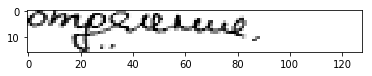

In [116]:
plt.imshow(pipeline.transform('w000000t003.png'), cmap='gray')

In [145]:
def train(model, imgs, labels, batch_size, transform_pipeline=BaseTransformer()):
    num = len(imgs)
    num_batches = num // batch_size
    ids = np.arange(num)
    np.random.shuffle(ids)
    for i in tqdm.tnrange(num_batches):
        batch_ids = ids[(i*batch_size):((i+1)*batch_size)]
        batch_imgs = [transform_pipeline.transform(x) for x in imgs[batch_ids]]
        batch_lbls = labels[batch_ids]
        loss = model.trainBatch(batch_imgs, batch_lbls)
        print('Batch: {}, loss: {}'.format(i, loss))
        
def validate(model, img, labels, batch_size, verbose=False):
    n_char_err = 0
    n_char = 0
    n_word_ok = 0
    n_word = 0
    num_batches = num // batch_size
    for i in range(num_batches):
        batch_imgs = imgs[(i*batch_size):((i+1)*batch_size)]
        batch_lbls = labels[(i*batch_size):((i+1)*batch_size)]
        recognized = model.inferBatch(batch_imgs)
        for j in range(len(recognized)):
            n_word_ok += int(batch_lbls[j] == recognized[j])
            n_word += 1
            dist = editdistance.eval(recognized[j], batch_lbls[j])
            n_char_err += dist
            n_char += len(batch_lbls[j])
            prefix = '[OK]' if dist==0 else '[ERR:{}]'.format(dist)
            if not verbose:
                print('{} "{}" -> "{}"'.format(prefix, batch_lbls[j], recognized[j]))

    cer = numCharErr / numCharTotal
    wa = numWordOK / numWordTotal
    if not verbose:
        print('Character error rate: {:.3f}. Word accuracy: {:.3f}.'.format(cer, wa))
    return cer, wa


def run_training(model, train_imgs, train_labels, valid_imgs, valid_labels,
                 batch_size=128, verbose=False, transform_pipeline=BaseTransformer()):
    epoch = 0
    while True:
        epoch += 1
        print('Epoch: {}'.format(epoch))

        train(model, train_imgs, train_labels, batch_size, transform_pipeline=transform_pipeline)
        cer, wa = validate(model, valid_imgs, valid_labels, batch_size, verbose=verbose)
        model.save()
        
def load_sample(sample, pipeline):
    imgs = [pipeline.transform('{}.png'.format(x)) for (x,_) in sample]
    lbls = [x for (_,x) in sample]
    return imgs, lbls

In [146]:
%%time
train_imgs, train_lbls = load_sample(train_sample, load_pipeline)

Wall time: 28.1 s


In [151]:
charlist = sorted(list(functools.reduce(set.union, [set(x) for x in train_lbls])))

In [160]:
%%time
model = HTRModel(charlist, img_size=(128, 16))

TypeError: Value passed to parameter 'input' has DataType bool not in list of allowed values: float16, float32